In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import cv2 as cv


2025-05-21 18:49:16.792782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747853356.976734      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747853357.031184      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# python librairies installation
!pip install split-folders matplotlib opencv-python spicy
import splitfolders

In [3]:
from pathlib import Path
dataset_Dir = '/kaggle/input/cottonweedid15/CottonWeedID15'
#dataset_Dir = Path(' /kaggle/input/cottonweedid15/CottonWeedID15/')
print(os.listdir (dataset_Dir))

num_classes = len(os.listdir (dataset_Dir))
print (num_classes)


['Nutsedge', 'Sicklepod', 'Morningglory', 'Ragweed', 'PalmerAmaranth', 'Waterhemp', 'Crabgrass', 'Swinecress', 'Prickly Sida', 'Carpetweeds', 'SpottedSpurge', 'SpurredAnoda', 'Eclipta', 'Goosegrass', 'Purslane']
15


In [4]:
redataset_Dir ='/kaggle/working/Weeddata_Split/'
ratio_list = [0.65, 0.2, 0.15]

# split data in a new folder named data-split
splitfolders.ratio (dataset_Dir, output=redataset_Dir, seed=1337, ratio=ratio_list, group_prefix=None, move=False)

Copying files: 5187 files [02:25, 35.56 files/s] 


In [5]:
# Define the image size and normalization parameters
IMAGE_SIZE = (224, 224)
COLOR_MODE = 'rgb'
BATCH_SIZE = 4
NUM_CLASSES = 15  # Define the number of classes for your dataset


# Define a function to load data and create generators
def create_data_generators(redataset_Dir):
    # Define the paths to the directories for training, validation, and testing data
    # train_data_dir = os.path.join(redataset_Dir, 'train')
    # valid_data_dir = os.path.join(redataset_Dir, 'val')
    # test_data_dir = os.path.join(redataset_Dir, 'test')


    # Create the train, validation, and test datasets using tf.keras.utils.image_dataset_from_directory
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(redataset_Dir, 'train'),
        label_mode='categorical',
        image_size=IMAGE_SIZE,
        color_mode=COLOR_MODE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    valid_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(redataset_Dir, 'val'),
        label_mode='categorical',
        image_size=IMAGE_SIZE,
        color_mode=COLOR_MODE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        os.path.join(redataset_Dir, 'test'),
        label_mode='categorical',
        image_size=IMAGE_SIZE,
        color_mode=COLOR_MODE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    return train_dataset, valid_dataset, test_dataset


In [6]:
train_dataset, valid_dataset, test_dataset = create_data_generators(redataset_Dir)

Found 3364 files belonging to 15 classes.


I0000 00:00:1747853522.153885      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747853522.154538      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1031 files belonging to 15 classes.
Found 792 files belonging to 15 classes.


In [7]:
image_batch, label_batch = next(iter(train_dataset))
i = 0
out = image_batch[i]
#print(image_batch[i])
print(np.max(image_batch[i]))
print(np.min(image_batch[i]))


255.0
1.9334917


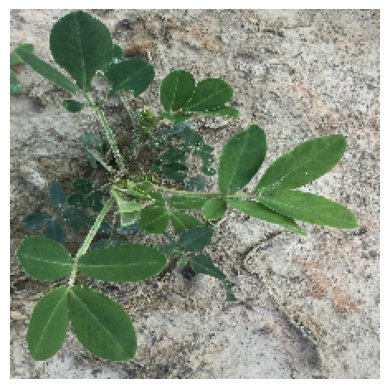

In [8]:
# prompt: show the image

import matplotlib.pyplot as plt

# Get the first image from the training dataset
image_batch, label_batch = next(iter(train_dataset))
first_image = image_batch[0]

# Show the image
plt.imshow(first_image.numpy().astype("uint8"))
plt.axis('off')
plt.show()


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
rescale_Func = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Create the train, validation, and test generators
normalized_train_dataset = train_dataset.map(lambda x, y: (rescale_Func(x), y))
normalized_valid_dataset = valid_dataset.map(lambda x, y: (rescale_Func(x), y))
normalized_test_dataset = test_dataset.map(lambda x, y: (rescale_Func(x), y))

image_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

-0.992798 1.0


In [11]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(1.0)
])

# Apply data augmentation to train_dataset
normalized_train_dataset = normalized_train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [12]:
# Load pre-trained ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

# Freeze convolutional base
for layer in base_model.layers:
    layer.trainable = True

# Add custom classification layers
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create new model
model = Model(inputs=base_model.input, outputs=predictions)

# Define SGD optimizer with momentum
sgd = SGD(learning_rate=0.001, momentum=0.9)

# Define learning rate schedule function
def lr_scheduler(epoch):
    initial_lr = 0.001
    decay_factor = 0.1
    epochs_drop = 7
    lr = initial_lr * np.power(decay_factor, np.floor((1 + epoch) / epochs_drop))
    return lr

# Compile the model with SGD optimizer and learning rate scheduler
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Define learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Train the model
history = model.fit(
    normalized_train_dataset,
    epochs=50,
    validation_data=normalized_valid_dataset,
    callbacks=[lr_scheduler_callback],
    #workers=tf.data.experimental.AUTOTUNE
)

Epoch 1/50


I0000 00:00:1747853615.907674      94 service.cc:148] XLA service 0x7abd6001d510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747853615.909939      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747853615.909962      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747853618.176515      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/841 ━━━━━━━━━━━━━━━━━━━━ 1:15 90ms/step - accuracy: 0.0000e+00 - loss: 3.6669   

I0000 00:00:1747853631.758964      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


841/841 ━━━━━━━━━━━━━━━━━━━━ 117s 88ms/step - accuracy: 0.5356 - loss: 1.5510 - val_accuracy: 0.4491 - val_loss: 2.1748 - learning_rate: 0.0010
Epoch 2/50
841/841 ━━━━━━━━━━━━━━━━━━━━ 52s 62ms/step - accuracy: 0.8014 - loss: 0.6013 - val_accuracy: 0.8594 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 3/50
841/841 ━━━━━━━━━━━━━━━━━━━━ 55s 65ms/step - accuracy: 0.8699 - loss: 0.4161 - val_accuracy: 0.8661 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 4/50
841/841 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - accuracy: 0.9153 - loss: 0.2453 - val_accuracy: 0.9214 - val_loss: 0.3056 - learning_rate: 0.0010
Epoch 5/50
841/841 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - accuracy: 0.9317 - loss: 0.2029 - val_accuracy: 0.8594 - val_loss: 0.6074 - learning_rate: 0.0010
Epoch 6/50
841/841 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - accuracy: 0.9509 - loss: 0.1595 - val_accuracy: 0.8535 - val_loss: 0.7331 - learning_rate: 0.0010
Epoch 7/50
841/841 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - accuracy: 0.9768 - loss: 0.073

In [14]:
# Load the test data
test_loss, test_accuracy = model.evaluate(normalized_test_dataset)

# Print training accuracy, validation accuracy, and test accuracy
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
print("Test Accuracy:", test_accuracy)




198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9308 - loss: 0.3206
Training Accuracy: 0.9976218938827515
Validation Accuracy: 0.9563530683517456
Test Accuracy: 0.939393937587738
